In [1]:
import numpy as np
import pandas as pd



In [6]:
def shooting_a(bs,s,ap,dmg,t,sv,w,n_shots=1):
    p_miss=(bs-1)/6
    p_hit=1-p_miss
    if s>=t*2:
        wound_on = 2
    elif s> t:
        wound_on = 3
    elif s==t:
        wound_on = 4
    elif s<=t/2:
        wound_on = 5
    else:
        wound_on = 6
        
    p_not_wound_=(wound_on-1)/6
    p_wound_=1-p_not_wound_
    p_not_wound=p_not_wound_*p_hit
    p_wound=p_wound_*p_hit

    sv=sv+ap
    p_not_sv_=(sv-1)/6
    p_sv_=1-p_not_sv_
    p_not_sv=p_not_sv_*p_wound
    p_sv=p_sv_*p_wound

    wounds=dmg*p_not_sv
    models=wounds/w

    ret=pd.Series({
        '# Hit': p_hit,
        '# Miss': p_miss,
        '# Wound': p_wound,
        '# fail to Wound': p_not_wound,
        '# Saved': p_sv,
        '# fail to Save': p_not_sv,
        '# Models Killed': models
    })
    ret*=n_shots
    return ret.to_frame('Expected')
    

In [23]:
r, b = 50, 50
table = [(r, b)]
while r > 1e-5 and b > 1e-5:
    b = max(b - shooting_a(4, 3, 0, 1, 3, 5, 1, n_shots=r).loc['# Models Killed', 'Expected'], 0)
    r = max(r - shooting_a(4, 3, 0, 1, 3, 5, 1, n_shots=b).loc['# Models Killed', 'Expected'], 0)
    table.append((r, b))
table = pd.DataFrame(
    table,
    columns=['# Red', '# Blue'],
    index=pd.Index(['Initial', *range(1, len(table))], name='Battle Round'))

<Axes: xlabel='Battle Round'>

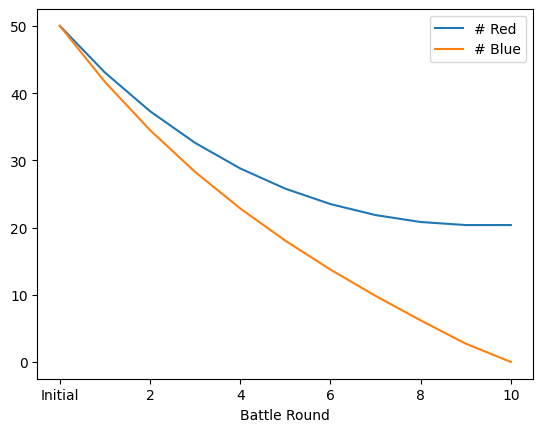

In [18]:
table.plot()

In [19]:
def d6(n):
    return np.random.randint(1, 7, n)

def shooting_s(bs, s, ap, dmg, t, sv, w, n_shots=1, n_iterations=1000):
    n_shots = np.broadcast_to(n_shots, n_iterations)
    n_d6 = n_shots.sum()

    did_hit = d6(n_d6) >= bs

    if s >= t * 2:
        wound_on = 2
    elif s > t:
        wound_on = 3
    elif s == t:
        wound_on = 4
    elif s <= t / 2:
        wound_on = 6
    else:
        wound_on = 5
    did_wound = did_hit & (d6(n_d6) >= wound_on)

    sv_ = sv + ap
    did_save = did_wound & (d6(n_d6) >= sv_)

    wounds = (did_wound & ~did_save) * dmg
    models = wounds / w

    return pd.DataFrame(dict(
        shot=np.arange(n_shots.sum()) - np.repeat(n_shots.cumsum() - n_shots, n_shots),
        run=np.repeat(np.arange(n_iterations), n_shots),
        did_hit=did_hit,
        did_wound=did_wound,
        did_save=did_save,
        wounds=wounds,
        models=models))

In [25]:
n_iterations = 1000000
r = pd.Series(10, index=range(n_iterations))
b = pd.Series(10, index=range(n_iterations))
while ((r != 0) & (b != 0)).any():
    r_shots = shooting_s(4, 3, 0, 1, 3, 5, 1, n_shots=r, n_iterations=len(r))
    b = b.subtract(r_shots.groupby('run').models.sum(), fill_value=0).clip(lower=0).astype(int)

    b_shots = shooting_s(4, 3, 0, 1, 3, 5, 1, n_shots=b, n_iterations=len(b))
    r = r.subtract(b_shots.groupby('run').models.sum(), fill_value=0).clip(lower=0).astype(int)

In [26]:
table2 = pd.concat([
    r[r > 0].value_counts().rename('Red Wins'),
    b[b > 0].value_counts().rename('Blue Wins'),
], axis=1)
table2 = table2.fillna(0).astype(int)
table2 /= table2.values.sum()

In [27]:
table2


,Red Wins,Blue Wins
7,0.105031,0.048133
6,0.101032,0.058543
8,0.092759,0.032004
5,0.086209,0.060260
4,0.068251,0.054881
9,0.062295,0.014977
3,0.049748,0.044426
2,0.032011,0.030714
10,0.023501,0.003731
1,0.015633,0.015861
